In [1]:
import pandas
import io
import uuid
import datetime
import pathlib
from fabric import Connection
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files
print(cur_dir)




C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python


In [2]:
location = "lille"
node = "chifflot-1"
c1 = Connection(host='ccaulier@access.grid5000.fr')
# print(c1.run("hostname"))
c2 = Connection(host='ccaulier@{}'.format(location), gateway=c1)
# print(c2.run("hostname"))
c = Connection(host='ccaulier@{}'.format(node), gateway=c2)

In [3]:
import time
def runExperiment(main_parallelism,notebook_dir, dataFileDirectory, remote_output_file, local_output_file, remote_throughput_file, local_throughput_file):
    c.run("./flink-1.18.1/bin/start-cluster.sh")
    # c.run("bash runPrometheusAndFlink.sh {} {}".format(main_parallelism, dataFileDirectory))
    # print("python fakePrometheus.py > throughput.dat &")

    c.run("bash runPrometheusBusynessPerVertexAndFlink.sh {} {} {}".format(main_parallelism, dataFileDirectory, "javaSource"))
    print("python fakePrometheusBusynessPerVertex.py > throughput.dat &")

    print("running flink jobs")
    time.sleep(5)
    c.get(remote_output_file, "%s/%s" % (notebook_dir, local_output_file))
    c.get(remote_throughput_file, "%s/%s" % (notebook_dir, local_throughput_file))
    c.run("flink-1.18.1/bin/stop-cluster.sh")
    

In [4]:
experimentName = "100000_150_javaSource_p_6"
experimentDirectory = "%s/experiments/experiment_%s/" % (cur_dir,experimentName)
dataDirectory = "param_100000_150.csv"
# pathlib.Path(experimentDirectory).mkdir(exist_ok=True, parents=True)
n_experiments = 5
main_parallelism = 6


In [5]:
for i in range(n_experiments):
    print("Experiment %s" % i)
    currentExperimentDirectory = "%s%s" % ( experimentDirectory, i )
    pathlib.Path(currentExperimentDirectory).mkdir(exist_ok=True, parents=True)

    runExperiment(main_parallelism, currentExperimentDirectory, dataDirectory, "output.dat", "output.dat", "throughput.dat", "throughput.dat")

Experiment 0
Starting cluster.
Starting standalonesession daemon on host chifflot-1.lille.grid5000.fr.
Starting taskexecutor daemon on host chifflot-1.lille.grid5000.fr.
[INFO] 1 instance(s) of taskexecutor are already running on chifflot-1.lille.grid5000.fr.
Starting taskexecutor daemon on host chifflot-1.lille.grid5000.fr.
[INFO] 2 instance(s) of taskexecutor are already running on chifflot-1.lille.grid5000.fr.
Starting taskexecutor daemon on host chifflot-1.lille.grid5000.fr.
Current working directory: /home/ccaulier
Benchmark is loaded from /home/ccaulier/flinkImplemProject.jar
Main parallelism: 6
Directory name: param_100000_150.csv
Benchmarking operator: MeanBasic with file: zipf,100000,150,1,1.0E-15
using java source
Job has been submitted with JobID efc65526d11961940f7259c5f2a0e75e
Program execution finished
Job with JobID efc65526d11961940f7259c5f2a0e75e has finished.
Job Runtime: 24702 ms

metric:MeanBasic,26239,6,0,0,zipf,100000,150,1,1.0E-15
Benchmarking operator: MeanBasic

In [6]:
import pandas as pd
import re

def parse_data_csvfile(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            csv_source = metric_data[5].split("_")
            # print(csv_source)
            csv_source[5] = csv_source[5].replace(".csv", "")
            if(csv_source[5] == "1.0E-15"):
                csv_source[5] = "0.0"
            # print(csv_source)
            csv_source.remove("distribution")
            for val in csv_source:
                metric_data.append(val)

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df


def parse_data_javaSource(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            metric_data.insert(5,"javaSource")
            metric_data[8], metric_data[9] = metric_data[9], metric_data[8]


            if(metric_data[10] == "1.0E-15"):
                metric_data[10] = "0.0"

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            print(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df

def save_dataframe_to_csv(df, output_path):
    df.to_csv(output_path, index=False)


# n_experiments = 3
main_df =pd.DataFrame()
for i in range(n_experiments):
    
    experimentFile = "%s%s/output.dat" % ( experimentDirectory, i )
    print(experimentFile)
    df= parse_data_javaSource(experimentFile)
    save_dataframe_to_csv(df,"%s%s/output.csv" % ( experimentDirectory, i ))
    main_df = pd.concat([main_df, df], ignore_index=True)

# main_df.to_csv(main_df)

C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiments/experiment_100000_150_javaSource_p_6/0/output.dat
['MeanBasic', '26239', '6', '0', '0', 'javaSource', 'zipf', '100000', '1', '150', '0.0', 24702]
['MeanBasic', '25400', '6', '0', '0', 'javaSource', 'zipf', '100000', '1', '150', '0.7', 23988]
['MeanBasic', '25326', '6', '0', '0', 'javaSource', 'zipf', '100000', '1', '150', '1.4', 23054]
['MeanBasic', '25309', '6', '0', '0', 'javaSource', 'zipf', '100000', '1', '150', '2.1', 22800]
['MeanBasic', '23302', '6', '0', '0', 'javaSource', 'zipf', '100000', '2', '150', '0.0', 22223]
['MeanBasic', '25299', '6', '0', '0', 'javaSource', 'zipf', '100000', '2', '150', '0.7', 23435]
['MeanBasic', '23275', '6', '0', '0', 'javaSource', 'zipf', '100000', '2', '150', '1.4', 21932]
['MeanBasic', '25283', '6', '0', '0', 'javaSource', 'zipf', '100000', '2', '150', '2.1', 22998]
['MeanBasic', '25284', '6', '0', '0', 'javaSource', 'zipf', '100000', '3', '150', '0.

In [7]:
main_df

,Operator,Duration,MainParallelism,HybridParallelism,Choices,CSVSource,distributionType,eventPerWindow,keySize,amountOfWindows,skew,Runtime (ms)
0,MeanBasic,26239,6,0,0,javaSource,zipf,100000,1,150,0.0,24702
1,MeanBasic,25400,6,0,0,javaSource,zipf,100000,1,150,0.7,23988
2,MeanBasic,25326,6,0,0,javaSource,zipf,100000,1,150,1.4,23054
3,MeanBasic,25309,6,0,0,javaSource,zipf,100000,1,150,2.1,22800
4,MeanBasic,23302,6,0,0,javaSource,zipf,100000,2,150,0.0,22223
...,...,...,...,...,...,...,...,...,...,...,...,...
235,MeanHybrid,35257,3,3,0,javaSource,zipf,100000,2,150,2.1,32831
236,MeanHybrid,37290,3,3,0,javaSource,zipf,100000,3,150,0.0,35097
237,MeanHybrid,35265,3,3,0,javaSource,zipf,100000,3,150,0.7,34311
238,MeanHybrid,35254,3,3,0,javaSource,zipf,100000,3,150,1.4,33445


In [8]:
import matplotlib.pyplot as plt

# Group data and calculate mean and range of runtime
main_df.drop(columns=['Duration'])
grouped = main_df.groupby(['Operator', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew'])
runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'}).reset_index()
# runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'})
runtime_stats['keySize']

0     1
1     1
2     1
3     1
4     2
5     2
6     2
7     2
8     3
9     3
10    3
11    3
12    1
13    1
14    1
15    1
16    2
17    2
18    2
19    2
20    3
21    3
22    3
23    3
24    1
25    1
26    1
27    1
28    2
29    2
30    2
31    2
32    3
33    3
34    3
35    3
36    1
37    1
38    1
39    1
40    2
41    2
42    2
43    2
44    3
45    3
46    3
47    3
Name: keySize, dtype: object

0    0.0
1    0.7
2    1.4
3    2.1
Name: skew, dtype: float64
12    0.0
13    0.7
14    1.4
15    2.1
Name: skew, dtype: float64
24    0.0
25    0.7
26    1.4
27    2.1
Name: skew, dtype: float64
36    0.0
37    0.7
38    1.4
39    2.1
Name: skew, dtype: float64
4    0.0
5    0.7
6    1.4
7    2.1
Name: skew, dtype: float64
16    0.0
17    0.7
18    1.4
19    2.1
Name: skew, dtype: float64
28    0.0
29    0.7
30    1.4
31    2.1
Name: skew, dtype: float64
40    0.0
41    0.7
42    1.4
43    2.1
Name: skew, dtype: float64
8     0.0
9     0.7
10    1.4
11    2.1
Name: skew, dtype: float64
20    0.0
21    0.7
22    1.4
23    2.1
Name: skew, dtype: float64
32    0.0
33    0.7
34    1.4
35    2.1
Name: skew, dtype: float64
44    0.0
45    0.7
46    1.4
47    2.1
Name: skew, dtype: float64


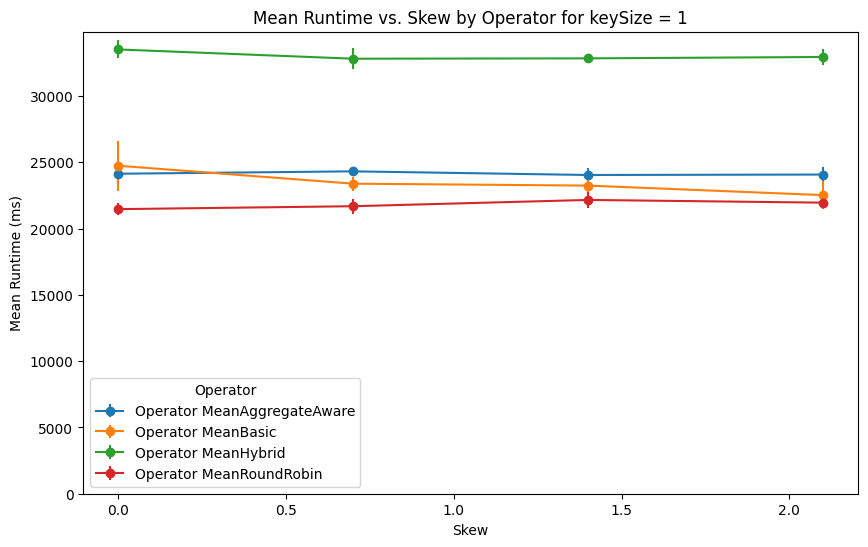

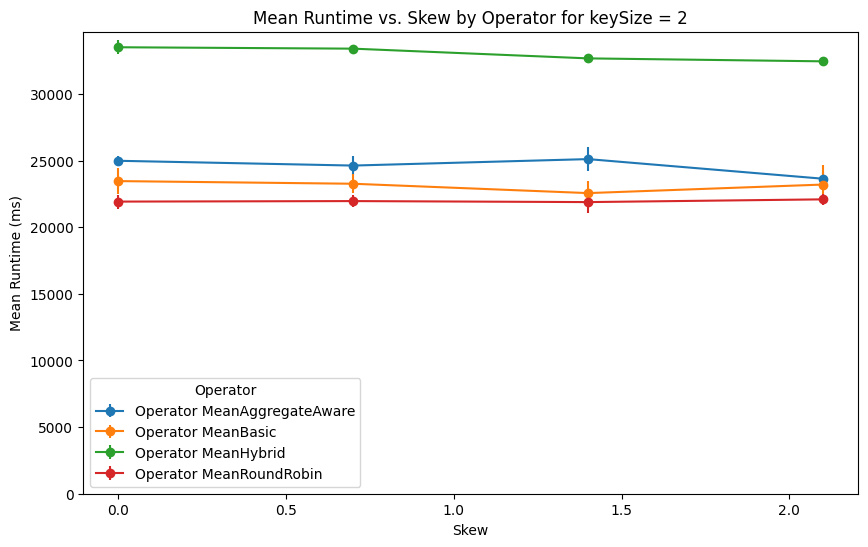

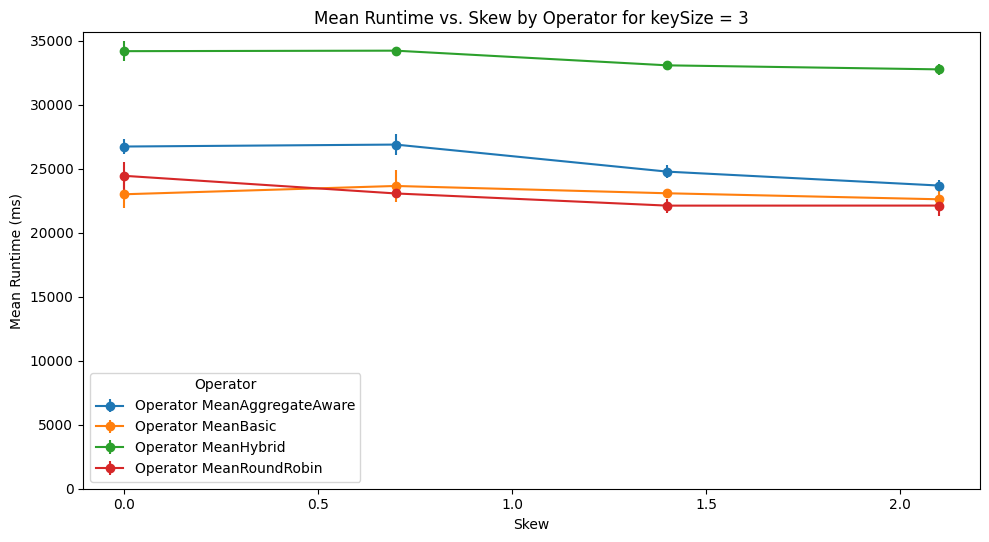

In [9]:

runtime_stats['skew'] = runtime_stats['skew'].astype(float)

sorted_runtime_stats = runtime_stats.sort_values(by='skew')
for i in range(1,3+1):
    keysize_2_data = runtime_stats[runtime_stats['keySize'] == str(i)].sort_values(by='skew')


    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            print(group['skew'])
            ax.errorbar(group['skew'], group['mean'], yerr=group['range']/2, fmt='-o', label=f'Operator {name}')
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Mean Runtime (ms)')
    ax.set_title('Mean Runtime vs. Skew by Operator for keySize = {}'.format(i))
    ax.legend(title='Operator')
     # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    # plt.show()
    plt.savefig(experimentDirectory+"plot{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()



In [14]:
import pandas as pd

# Assume df is your DataFrame
main_df.to_csv(experimentDirectory+"dataframe.csv", index=False)